# GMM - Anomaly Detection

En éste notebook vamos a explorar las aplicaciones de los Gaussian Mixture Models a la detección de anomalías.

## Cargamos las Librerías

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture

## Datasets Sintéticos

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

Usamos make_blobs de sklearn para generar datasets sintéticos. [Documentación](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [24]:
# Dataset original
X, y_true = make_blobs(n_samples=1000, centers=5, cluster_std=0.60, random_state=1)

# Outliers
X_append, y_true_append = make_blobs(n_samples=50,centers=5, cluster_std=5,random_state=1)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.30, random_state=1, shuffle=True)

Text(0.5, 1.0, 'Valores normales')

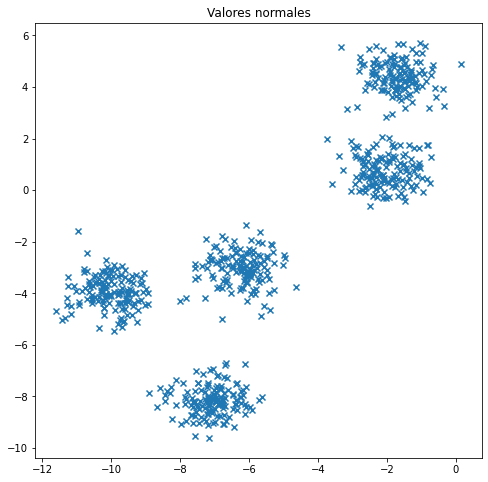

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(X_train[:,0],X_train[:,1],marker="x")
plt.title("Valores normales")

Text(0.5, 1.0, 'Valores Anómalos')

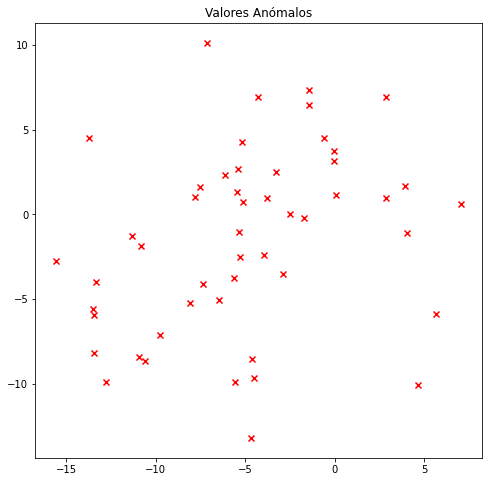

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(X_append[:,0],X_append[:,1],marker="x", c='r')
plt.title("Valores Anómalos")

In [29]:
gm = GaussianMixture(n_components = 5, covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(n_components=5, random_state=0)

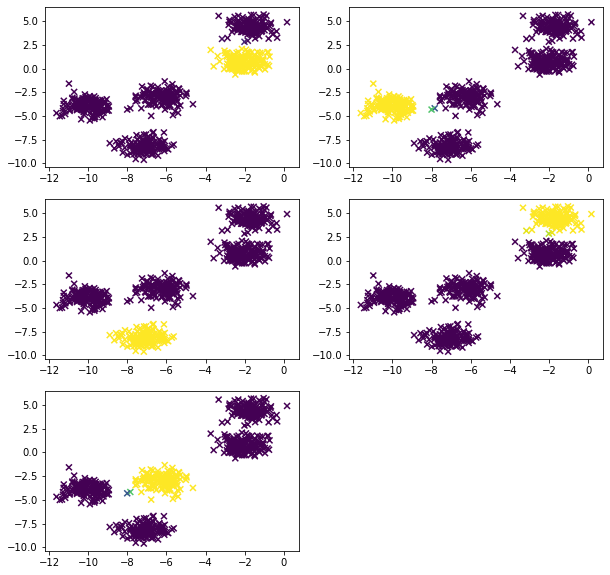

In [30]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

In [41]:
log_prob_train = gm.score_samples(X=X_train)

In [36]:
log_prob = gm.score_samples(X=X_append)

In [37]:
log_prob.shape

(50,)

Text(0.5, 0, 'Logaritmo densidad de probabilidad')

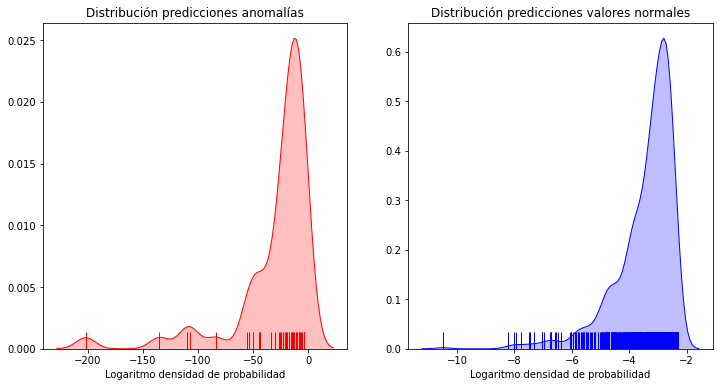

In [45]:
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.distplot(
    log_prob,
    hist    = False,
    rug     = True,
    color   = 'red',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax_1
)

ax_1.set_title('Distribución predicciones anomalías')
ax_1.set_xlabel('Logaritmo densidad de probabilidad')

sns.distplot(
    log_prob_train,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax_2
)

ax_2.set_title('Distribución predicciones valores normales')
ax_2.set_xlabel('Logaritmo densidad de probabilidad')

In [49]:
# Tomamos como umbral log_prob <-10

anomaly_mask = log_prob<-8
y = np.zeros(X_append.shape[0])
y[anomaly_mask]=1

In [50]:
np.sum(y)

41.0

Text(0.5, 1.0, 'Distribución puntos normales')

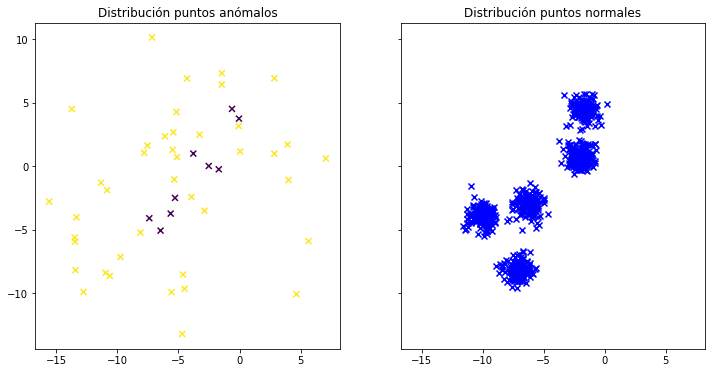

In [54]:
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey='row', sharex='row')

ax_1.scatter(X_append[:,0], X_append[:,1], marker="x", c=y, cmap='viridis')
ax_1.set_title("Distribución puntos anómalos")

ax_2.scatter(X_train[:,0], X_train[:,1], marker="x", c='b')
ax_2.set_title("Distribución puntos normales")

## Dataset Old Faithful

### Cargamos los Datos

Es un dataset que contiene información sobre la duración e intervalos entre erupciones del geiser de Yellowstone.

In [62]:
data = pd.read_csv('data/OldFaithful.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   waiting   299 non-null    int64  
 1   duration  299 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


In [63]:
data.describe()

,waiting,duration
count,299.000000,299.000000
mean,72.314381,3.460814
std,13.890324,1.147904
min,43.000000,0.833333
25%,59.000000,2.000000
50%,76.000000,4.000000
75%,83.000000,4.383333
max,108.000000,5.450000


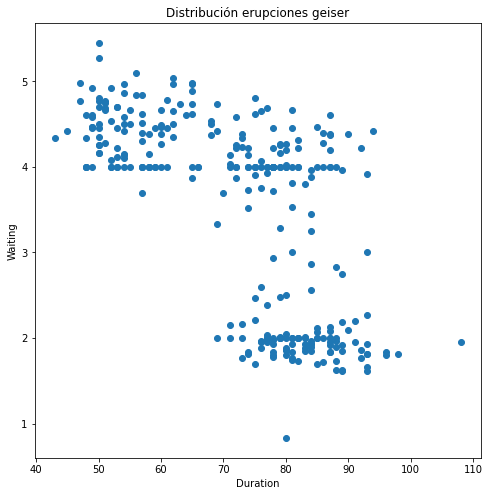

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

ax.scatter(data.waiting, data.duration)
ax.set_title('Distribución erupciones geiser')
ax.set_ylabel('Waiting')
ax.set_xlabel('Duration');

A simpe vista, pareciera que hay tres clusters bien marcados. Podemos entrenar entonces un modelo con GMM e intentar identificar las anomalías a partir del mísmo.

In [65]:
gm = GaussianMixture(n_components = 3, covariance_type = 'diag', random_state = 123)
gm.fit(X=data)

GaussianMixture(covariance_type='diag', n_components=3, random_state=123)

In [66]:
log_prob = gm.score_samples(X=data)

Como no conocemos cuáles son las anomalías de nuestro dataset y no tenemos un dataset de valores normales (con alto nivel de confianza) sobre el cual entrenar el modelo, vamos a escoger como anomalías los 20 puntos con menor log de distribución de probabilidad. Lo ideal sería utilizar un umbral como en el ejemplo de más arriba.

In [68]:
df_resultados = data.copy()
df_resultados['log_proba'] = log_prob
df_resultados = df_resultados.sort_values(by='log_proba')

anomalias = df_resultados.head(20)
anomalias

,waiting,duration,log_proba
148,80,0.833333,-14.168780
60,108,1.950000,-10.363347
242,93,3.000000,-10.010828
26,88,2.833333,-9.262396
269,89,2.750000,-8.861988
169,84,2.866667,-8.661795
11,50,5.450000,-8.160330
109,78,2.933333,-8.001557
83,81,3.000000,-7.592703
34,76,2.600000,-7.392119


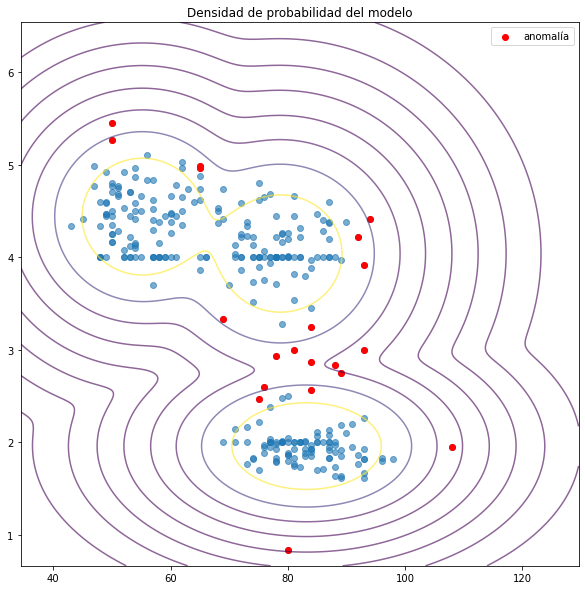

In [70]:
# Graficamos los resultados (sacado de scikit learn y bibliografía)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# Grid de valores dentro del rango observado
x = np.linspace(min(data.waiting)*0.8, max(data.waiting)*1.2, 1000)
y = np.linspace(min(data.duration)*0.8, max(data.duration)*1.2, 1000)
xx, yy = np.meshgrid(x, y)

# Densidad de probabilidad de cada valor del grid
scores = gm.score_samples(np.c_[xx.ravel(), yy.ravel()])

# Los valores están en log
scores = np.exp(scores) 

ax.scatter(data.waiting, data.duration, alpha=0.6)
ax.scatter(anomalias.waiting, anomalias.duration, c="red", label='anomalía')
ax.contour(
    xx, yy, scores.reshape(xx.shape),
    alpha=0.6, cmap='viridis',
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
ax.set_title('Densidad de probabilidad del modelo')
ax.legend();

---

## Bibliografía

* Anomaly Detection in Python with Gaussian Mixture Models. Agasti Kishor Dukare
* Detección de anomalías con Gaussian Minture Modedel (GMM) y python. Joaquín Amat Rodrigo